This notebook aims to follow along with Aki Vehtari's [Roaches CV demo](https://users.aalto.fi/~ave/modelselection/roaches.html) but using the `pymc` library and the newest [Arviz](https://arviz-base.readthedocs.io/en/latest/)  

SO far my attempt to get it to install is to use my yml but then do a :

```bash
pip install arviz-base
pip install "arviz-stats[xarray]"
pip install "arviz-plots[matplotlib]"
```

TODO: Move these pip installs to the yml file when i figure out how to make it work. (NB> seems to work fine on mac, not on pc yet)


In [1]:
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import arviz_base as azb
import arviz_stats as azs
import arviz_plots as azp
#import arviz as az

To get this data, I used rstararm and `data(roaches)` in R and then exported it to a csv file.  

The data consists of :

- `y`: the number of roaches caught.
- `roach1`: pretreatment roach level. (float)
- `senior`: indicates if the apartment is intended for seniors . 
- `exposure2` : the number of trap-days (days  x traps) . 
- `treatment`: indicates if the apartment was treated with a pesticide.  

NOTE: In this[Bambi notebook](https://bambinos.github.io/bambi/notebooks/count_roaches.html) I used this data as an example of using `offset` in Bambi. 

In [3]:
roaches = pd.read_csv("data/roaches.csv")
# rescale 
roaches["sqrt_roach1"] = np.sqrt(roaches["roach1"]) # transform to make less skewed
roaches.head()

,y,roach1,treatment,senior,exposure2,sqrt_roach1
0,153,308.00,1,0,0.800000,17.549929
1,127,331.25,1,0,0.600000,18.200275
2,7,1.67,1,0,1.000000,1.292285
3,7,3.00,1,0,1.000000,1.732051
4,0,2.00,1,0,1.142857,1.414214


## Poisson model

Here we want to fit a Poisson model, `y ~ sqrt_roach1 + treatment +  senior`, to the data with the offset `log(exposure2)`.

In [4]:

mean_sqrt_roach1 = roaches["sqrt_roach1"].mean()

with pm.Model() as base_model:
    # Data
    sqrt_roach1_c = pm.Data("sqrt_roach1_c", roaches["sqrt_roach1"]- mean_sqrt_roach1) # center the data
    offset = pm.Data("offset",np.log(roaches["exposure2"])) # see bambi notebook for explanation
    senior = pm.Data("senior", roaches["senior"])  # center the data
    treatment = pm.Data("treatment", roaches["treatment"])
    y_data = pm.Data("y_data", roaches["y"])  

    # Priors
    b_sqrt_roach1 = pm.Normal("b_sqrt_roach1", mu=0, sigma=1)
    b_treatment = pm.Normal("b_treatment", mu=0, sigma=1)
    b_senior = pm.Normal("b_senior", mu=0, sigma=1)  
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    
    
    mu = pm.Deterministic("mu",  intercept + b_sqrt_roach1*sqrt_roach1_c + b_treatment*treatment + b_senior*senior + offset)
    
    count = pm.Deterministic("count", pm.math.exp(mu))

poisson_model = base_model.copy()

with poisson_model:

    # Likelihood
    y= pm.Poisson("y", mu=poisson_model['count'], observed=poisson_model['y_data'])

    # Sample from the posterior
    trace_poisson = pm.sample()
    


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


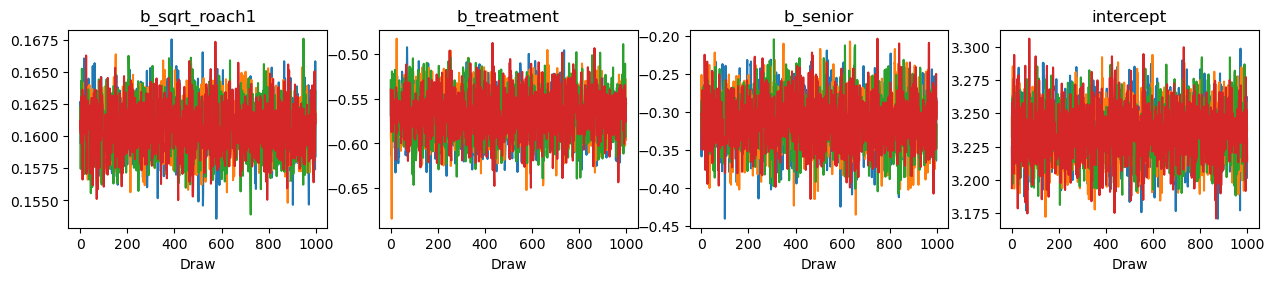

In [5]:

azp.plot_trace(trace_poisson,  var_names=["b_sqrt_roach1", "b_treatment", "b_senior", "intercept"]);

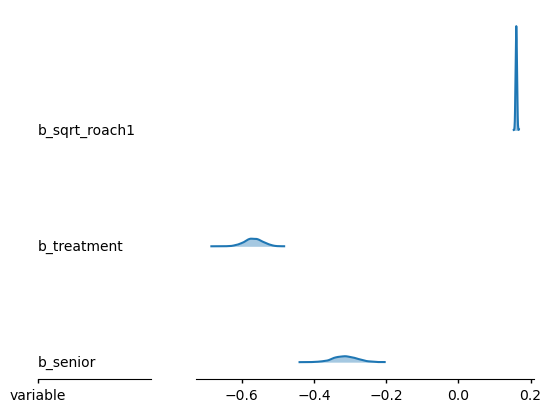

In [6]:
azp.plot_ridge(trace_poisson, var_names=["b_sqrt_roach1", "b_treatment", "b_senior"], combined = True)

We can see right away that this model is not good, the data is overdispersed.

In [7]:
# borrowed from my other notebook, helper function. 
def plot_log_posterior_ppc(idata):
    # plot posterior predictive check
    var_name = 'log(y+1)'
    # there is probably a better way
    idata.posterior_predictive[var_name] = np.log(idata.posterior_predictive['y'] + 1)
    idata.observed_data[var_name] = np.log(idata.observed_data['y'] + 1)
    
    return azp.plot_ppc_dist(idata, var_names = var_name)


Sampling: [y]


Output()

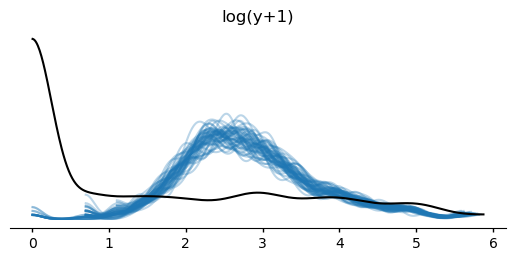

In [ ]:
with poisson_model:
   pp_poisson =  pm.sample_posterior_predictive(trace_poisson) # note, i dont use extend_inference here as it messes up loo-pit

plot_log_posterior_ppc(pp_poisson)

The model selection notebook looks at the PSIS diagnostics, so lets try that here. 

/var/folders/ky/7fzpzfg13g9ggl74h1z_2kkr0000gn/T/ipykernel_98352/2911090072.py:1: UserWarning: Detected at least one discrete variable.
Consider using plot_ppc variants specific for discrete data, such as plot_ppc_pava or plot_ppc_rootogram.
  azp.plot_ppc_dist(pp_poisson, var_names = "y",kind = "ecdf")


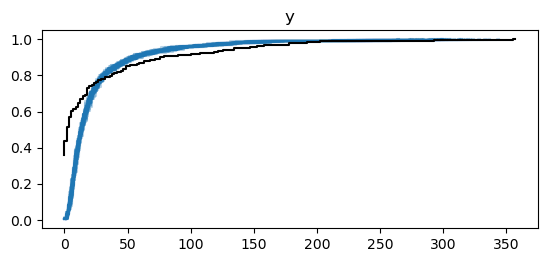

In [12]:
azp.plot_ppc_dist(pp_poisson, var_names = "y",kind = "ecdf")

In [13]:
# add log likelihood
with poisson_model:
    pm.compute_log_likelihood(trace_poisson, extend_inferencedata=True)

Output()

In [14]:
loo_poisson = azs.loo(trace_poisson)
loo_poisson

/Users/ronaldlegere/miniconda3/envs/pymc_bda3/lib/python3.13/site-packages/arviz_stats/loo/helper_loo.py:857: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 262 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5459.04   694.11
p_loo      255.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      248   94.7%
   (0.70, 1]   (bad)         6    2.3%
    (1, Inf)   (very bad)    8    3.1%

We see some points hae high Pareto k values

R has a nice method for `plot` that will just plot the pareto_k values. In arviz this is called `plot_khat`.
In the new arviz-plots I cannnot find an equivalent. 

<Axes: >

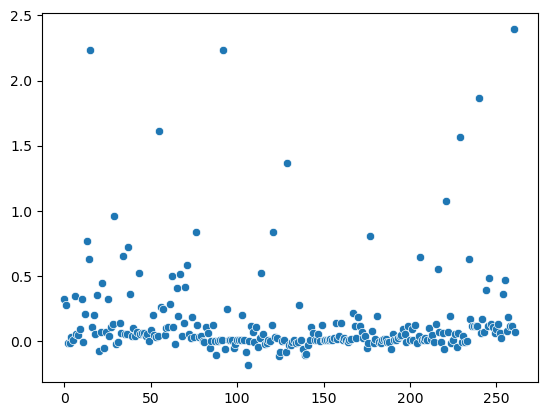

In [15]:
sns.scatterplot(loo_poisson.pareto_k)

There are several observation with high Pareto k values, and so these are very influential to the loo calculation, and also indicate model mis-specification.

Sampling: [y]


Output()

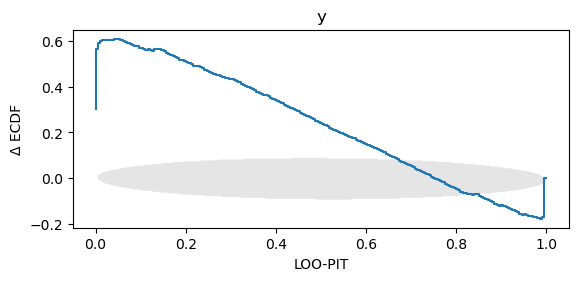

In [16]:
with poisson_model:
    pm.sample_posterior_predictive(trace_poisson, extend_inferencedata=True)
azp.plot_loo_pit(trace_poisson)

This shows the probability integral transform (PIT)  (https://arviz-devs.github.io/EABM/Chapters/Prior_posterior_predictive_checks.html#pit-ecdfs)

Now that we know we will want log likelihoods, we can pass in `idata_kwargs={"log_likelihood": True}` to the `sample` method in the future. Lets go ahead and move on to the negative binomial model.

## Negative Binomial model

In [13]:
nbinom_model = base_model.copy()
with nbinom_model:
    # Priors
    alpha = pm.Gamma("alpha", mu=1, sigma=3)  # shape parameter for negative binomial

    # Likelihood
    y = pm.NegativeBinomial("y", mu=nbinom_model["count"], alpha = alpha, observed=nbinom_model['y_data'])

    # Sample from the posterior
    trace_nbinom = pm.sample(idata_kwargs = {"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_sqrt_roach1, b_treatment, b_senior, intercept, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [y]


Output()

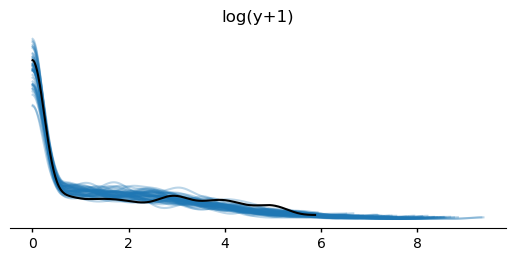

In [14]:
with nbinom_model:
  pp_nbinom =   pm.sample_posterior_predictive(trace_nbinom)

plot_log_posterior_ppc(pp_nbinom)

Posterior predictive check is MUCH better.

Sampling: [y]


Output()

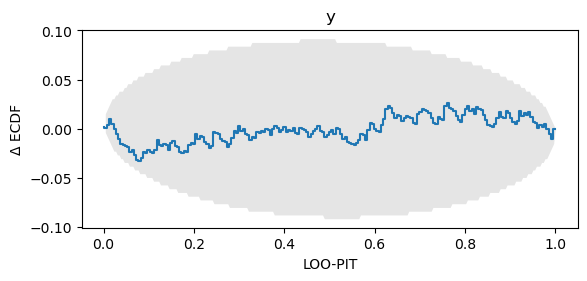

In [15]:
with nbinom_model: 
    pm.sample_posterior_predictive(trace_nbinom, extend_inferencedata=True)

azp.plot_loo_pit(trace_nbinom) 

/Users/ronaldlegere/miniconda3/envs/pymc_bda3/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: >

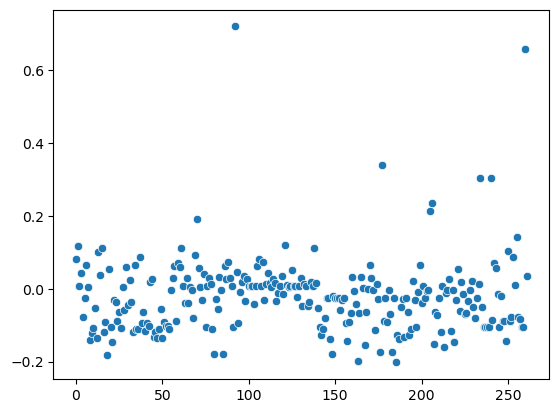

In [90]:
loo_nb = az.loo(trace_nbinom)
sns.scatterplot(loo_nb.pareto_k)

Only a few outliers, and none are > 1. 

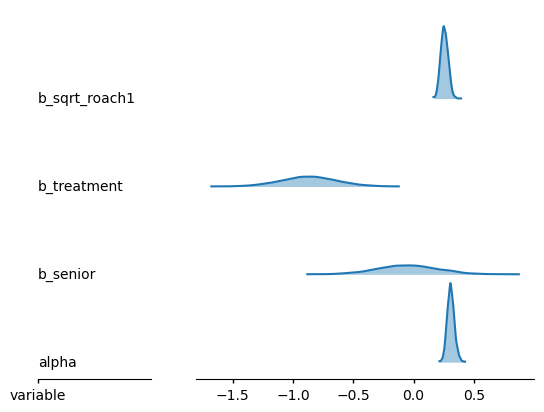

In [93]:
azp.plot_ridge(trace_nbinom,
               var_names=["b_sqrt_roach1", "b_treatment", "b_senior","alpha"])

Note that the treatment effect is much smaller, and that the senior effect is not overlapping with zero. I also plot alpha so that we can see that overdispersion is significant.